### LSTM Example

From: https://github.com/andrei-radulescu-banu/stat453-deep-learning-ss21/blob/main/L15/packed_lstm.ipynb

### Imports

In [1]:
import torch
import torch.nn.functional as F
import torchtext
import time
import random
import pandas as pd
import json
from tqdm import tqdm
import os
import re

from sqlalchemy.orm import Session
from sqlalchemy import create_engine, select, MetaData, Table
from sqlalchemy.ext.automap import automap_base

### Settings and Hyperparameters

In [2]:
with open ('../settings.json') as f:
    settings = json.load(f)

db_uri = settings['sqlalchemy_database_uri']

RANDOM_SEED = 123
torch.manual_seed(RANDOM_SEED)

VOCABULARY_SIZE = 20000
LEARNING_RATE = 0.005
BATCH_SIZE = 128
NUM_EPOCHS = 15
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

EMBEDDING_DIM = 128
HIDDEN_DIM = 256
NUM_CLASSES = 2

### Download Dataset

In [3]:
# !wget https://github.com/rasbt/python-machine-learning-book-3rd-edition/raw/master/ch08/movie_data.csv.gz -O ~/data/movie_data.csv.gz

In [4]:
# !gunzip -f ~/data/movie_data.csv.gz 

### Load and Check Data

In [5]:
df = pd.read_csv('~/data/movie_data.csv')
df.head()

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0


### Prepare Dataset

In [6]:
from torchdata.datapipes.iter import IterableWrapper, FileOpener
datapipe = IterableWrapper(["/home/mike/data/movie_data.csv"])
datapipe = FileOpener(datapipe, mode='b')
dp = datapipe.parse_csv(skip_lines=1)

for sample in dp:
     print(sample)
     break

['In 1974, the teenager Martha Moxley (Maggie Grace) moves to the high-class area of Belle Haven, Greenwich, Connecticut. On the Mischief Night, eve of Halloween, she was murdered in the backyard of her house and her murder remained unsolved. Twenty-two years later, the writer Mark Fuhrman (Christopher Meloni), who is a former LA detective that has fallen in disgrace for perjury in O.J. Simpson trial and moved to Idaho, decides to investigate the case with his partner Stephen Weeks (Andrew Mitchell) with the purpose of writing a book. The locals squirm and do not welcome them, but with the support of the retired detective Steve Carroll (Robert Forster) that was in charge of the investigation in the 70\'s, they discover the criminal and a net of power and money to cover the murder.<br /><br />"Murder in Greenwich" is a good TV movie, with the true story of a murder of a fifteen years old girl that was committed by a wealthy teenager whose mother was a Kennedy. The powerful and rich fami

In [7]:
# Split into training, validation, and test sets

# Get the number of rows in dataset
N_ROWS = len(list(dp)) 
N_train = int(N_ROWS * 0.8)
N_valid = int(N_ROWS * 0.1)
N_test = N_ROWS - N_train - N_valid

# Split into training and val datapipes early on. Will build vocabulary from training datapipe only.
train_dp, valid_dp, test_dp = dp.random_split(total_length=N_ROWS, weights={"train": N_train, "valid": N_valid, "test": N_test}, seed=RANDOM_SEED)

print(f'Num Train: {len(train_dp)}')
print(f'Num Validate: {len(valid_dp)}')
print(f'Num Test: {len(test_dp)}')

Num Train: 40000
Num Validate: 5000
Num Test: 5000


### Build Vocab

In [8]:
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer(tokenizer='basic_english')

def yield_tokens(data_iter):
    for text, _ in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_dp), specials=["<unk>", "<pad>"],  max_tokens=VOCABULARY_SIZE)
vocab.set_default_index(vocab["<unk>"])
PADDING_VALUE=vocab['<PAD>']

In [9]:
print(f'Vocab Size: {len(vocab)}')
print(vocab.get_itos()[:10]) # itos = integer-to-string

Vocab Size: 20000
['<unk>', '<pad>', 'the', '.', ',', 'and', 'a', 'of', 'to', "'"]


In [10]:
text_transform = lambda x: [vocab[token] for token in tokenizer(x)]
label_transform = lambda x: 1 if x == '1' else 0

# Print out the output of text_transform
print("input to the text_transform:", "here is an example")
print("output of the text_transform:", text_transform("here is an example"))

input to the text_transform: here is an example
output of the text_transform: [135, 10, 41, 475]


In [11]:
list(train_dp)[0]

['In 1974, the teenager Martha Moxley (Maggie Grace) moves to the high-class area of Belle Haven, Greenwich, Connecticut. On the Mischief Night, eve of Halloween, she was murdered in the backyard of her house and her murder remained unsolved. Twenty-two years later, the writer Mark Fuhrman (Christopher Meloni), who is a former LA detective that has fallen in disgrace for perjury in O.J. Simpson trial and moved to Idaho, decides to investigate the case with his partner Stephen Weeks (Andrew Mitchell) with the purpose of writing a book. The locals squirm and do not welcome them, but with the support of the retired detective Steve Carroll (Robert Forster) that was in charge of the investigation in the 70\'s, they discover the criminal and a net of power and money to cover the murder.<br /><br />"Murder in Greenwich" is a good TV movie, with the true story of a murder of a fifteen years old girl that was committed by a wealthy teenager whose mother was a Kennedy. The powerful and rich fami

In [12]:
from torch.utils.data import DataLoader 
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Sampler

# following two helper functions from https://medium.com/@bitdribble/migrate-torchtext-to-the-new-0-9-0-api-1ff1472b5d71
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch

def collate_batch(batch):
    text_list, label_list = [], []
    for (_text, _label) in batch:
        processed_text = torch.tensor(text_transform(_text))
        text_list.append(processed_text)
        label_list.append(label_transform(_label))
    return pad_sequence(text_list, padding_value=PADDING_VALUE).to(DEVICE), torch.tensor(label_list).to(DEVICE)

class BatchSamplerSimilarLength(Sampler):
    def __init__(self, dataset, batch_size, indices=None, shuffle=True):
        self.batch_size = batch_size
        self.shuffle = shuffle
        # get the indices and length
        self.indices = [(i, len(tokenizer(s[1]))) for i, s in enumerate(dataset)]
        # if indices are passed, then use only the ones passed (for ddp)
        if indices is not None:
            self.indices = torch.tensor(self.indices)[indices].tolist()

    def __iter__(self):
        if self.shuffle:
            random.shuffle(self.indices)

        pooled_indices = []
        # create pool of indices with similar lengths
        for i in range(0, len(self.indices), self.batch_size * 100):
            pooled_indices.extend(sorted(self.indices[i:i + self.batch_size * 100], key=lambda x: x[1]))
        self.pooled_indices = [x[0] for x in pooled_indices]

        # yield indices for current batch
        batches = [self.pooled_indices[i:i + self.batch_size] for i in
               range(0, len(self.pooled_indices), self.batch_size)]

        if self.shuffle:
            random.shuffle(batches)
        for batch in batches:
            yield batch

    def __len__(self):
        return len(self.pooled_indices) // self.batch_size



In [13]:
train_dp_list = list(train_dp)
valid_dp_list = list(valid_dp)
test_dp_list = list(test_dp)

train_loader = DataLoader(train_dp_list, 
                          batch_sampler=BatchSamplerSimilarLength(dataset = train_dp_list, 
                                                                  batch_size=BATCH_SIZE),
                          collate_fn=collate_batch)
valid_loader = DataLoader(train_dp_list, 
                          batch_sampler=BatchSamplerSimilarLength(dataset = valid_dp_list, 
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=False),
                          collate_fn=collate_batch)
test_loader = DataLoader(train_dp_list, 
                          batch_sampler=BatchSamplerSimilarLength(dataset = test_dp_list, 
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=False),
                          collate_fn=collate_batch)

text_batch, label_batch = next(iter(train_loader))
print(text_batch.size())
print(label_batch.size())

torch.Size([1055, 128])
torch.Size([128])


In [14]:
print('Train')
for text_batch, label_batch in train_loader:
    print(f'Text matrix size: {text_batch.size()}')
    print(f'Target vector size: {label_batch.size()}')
    break
    
print('\nValid:')
for text_batch, label_batch in valid_loader:
    print(f'Text matrix size: {text_batch.size()}')
    print(f'Target vector size: {label_batch.size()}')
    break
    
print('\nTest:')
for text_batch, label_batch in test_loader:
    print(f'Text matrix size: {text_batch.size()}')
    print(f'Target vector size: {label_batch.size()}')
    break

Train
Text matrix size: torch.Size([1093, 128])
Target vector size: torch.Size([128])

Valid:
Text matrix size: torch.Size([1062, 128])
Target vector size: torch.Size([128])

Test:
Text matrix size: torch.Size([1062, 128])
Target vector size: torch.Size([128])


### Utility Functions

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def compute_accuracy(model, data_loader, device):

    with torch.no_grad():

        correct_pred, num_examples = 0, 0

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.float().to(device)

            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)

            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum().to("cpu")

    return float(correct_pred)/num_examples * 100


def train_model(model, num_epochs, train_loader,
                valid_loader, test_loader, optimizer,
                device, logging_interval=50,
                scheduler=None,
                scheduler_on='valid_acc'):

    start_time = time.time()
    minibatch_loss_list, train_acc_list, valid_acc_list = [], [], []
    
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(device)
            targets = targets.to(device)

            # ## FORWARD AND BACK PROP
            logits = model(features)
            loss = torch.nn.functional.cross_entropy(logits, targets)
            optimizer.zero_grad()

            loss.backward()

            # ## UPDATE MODEL PARAMETERS
            optimizer.step()

            # ## LOGGING
            minibatch_loss_list.append(loss.item())
            if not batch_idx % logging_interval:
                print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
                      f'| Batch {batch_idx:04d}/{len(train_loader):04d} '
                      f'| Loss: {loss:.4f}')

        model.eval()
        with torch.no_grad():  # save memory during inference
            train_acc = compute_accuracy(model, train_loader, device=device)
            valid_acc = compute_accuracy(model, valid_loader, device=device)
            print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
                  f'| Train: {train_acc :.2f}% '
                  f'| Validation: {valid_acc :.2f}%')
            train_acc_list.append(train_acc)
            valid_acc_list.append(valid_acc)

        elapsed = (time.time() - start_time)/60
        print(f'Time elapsed: {elapsed:.2f} min')
        
        if scheduler is not None:

            if scheduler_on == 'valid_acc':
                scheduler.step(valid_acc_list[-1])
            elif scheduler_on == 'minibatch_loss':
                scheduler.step(minibatch_loss_list[-1])
            else:
                raise ValueError(f'Invalid `scheduler_on` choice.')
        

    elapsed = (time.time() - start_time)/60
    print(f'Total Training Time: {elapsed:.2f} min')

    test_acc = compute_accuracy(model, test_loader, device=device)
    print(f'Test accuracy {test_acc :.2f}%')

    return minibatch_loss_list, train_acc_list, valid_acc_list

def plot_training_loss(minibatch_loss_list, num_epochs, iter_per_epoch,
                       results_dir=None, averaging_iterations=100):

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(range(len(minibatch_loss_list)),
             (minibatch_loss_list), label='Minibatch Loss')

    if len(minibatch_loss_list) > 1000:
        ax1.set_ylim([
            0, np.max(minibatch_loss_list[1000:])*1.5
            ])
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')

    ax1.plot(np.convolve(minibatch_loss_list,
                         np.ones(averaging_iterations,)/averaging_iterations,
                         mode='valid'),
             label='Running Average')
    ax1.legend()

    ###################
    # Set scond x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))

    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())
    ###################

    plt.tight_layout()

    if results_dir is not None:
        image_path = os.path.join(results_dir, 'plot_training_loss.pdf')
        plt.savefig(image_path)


def plot_accuracy(train_acc_list, valid_acc_list, results_dir):

    num_epochs = len(train_acc_list)

    plt.plot(np.arange(1, num_epochs+1),
             train_acc_list, label='Training')
    plt.plot(np.arange(1, num_epochs+1),
             valid_acc_list, label='Validation')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()

    if results_dir is not None:
        image_path = os.path.join(
            results_dir, 'plot_acc_training_validation.pdf')
        plt.savefig(image_path)

### LSTM Model

In [16]:
class LSTM(torch.nn.Module):
    
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()

        self.embedding = torch.nn.Embedding(input_dim, embedding_dim)
        
        self.rnn = torch.nn.LSTM(embedding_dim,
                                 hidden_dim)        
        
        self.fc = torch.nn.Linear(hidden_dim, output_dim)
        

    def forward(self, text):
        # text dim: [sentence length, batch size]        
        embedded = self.embedding(text)
        # embedded dim: [sentence length, batch size, embedding dim]
        
        output, (hidden, cell) = self.rnn(embedded)
        # output dim: [sentence length, batch size, hidden dim]
        # hidden dim: [1, batch size, hidden dim]

        hidden.squeeze_(0)
        # hidden dim: [batch size, hidden dim]
        
        output = self.fc(hidden)
        return output

### Train Model

In [17]:
model = LSTM(input_dim=len(vocab),
             embedding_dim=EMBEDDING_DIM,
             hidden_dim=HIDDEN_DIM,
             output_dim=NUM_CLASSES # could use 1 for binary classification
)

model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    logging_interval=100)

Epoch: 001/015 | Batch 0000/0312 | Loss: 0.6923
Epoch: 001/015 | Batch 0100/0312 | Loss: 0.6880
Epoch: 001/015 | Batch 0200/0312 | Loss: 0.6931
Epoch: 001/015 | Batch 0300/0312 | Loss: 0.6955
Epoch: 001/015 | Train: 49.82% | Validation: 49.36%
Time elapsed: 0.61 min
Epoch: 002/015 | Batch 0000/0312 | Loss: 0.6921
Epoch: 002/015 | Batch 0100/0312 | Loss: 0.6901
Epoch: 002/015 | Batch 0200/0312 | Loss: 0.6971
Epoch: 002/015 | Batch 0300/0312 | Loss: 0.6940
Epoch: 002/015 | Train: 50.36% | Validation: 50.78%
Time elapsed: 1.19 min
Epoch: 003/015 | Batch 0000/0312 | Loss: 0.6867
Epoch: 003/015 | Batch 0100/0312 | Loss: 0.6900
Epoch: 003/015 | Batch 0200/0312 | Loss: 0.6877
Epoch: 003/015 | Batch 0300/0312 | Loss: 0.6938
Epoch: 003/015 | Train: 50.39% | Validation: 50.84%
Time elapsed: 1.77 min
Epoch: 004/015 | Batch 0000/0312 | Loss: 0.6903
Epoch: 004/015 | Batch 0100/0312 | Loss: 0.6985
Epoch: 004/015 | Batch 0200/0312 | Loss: 0.6903
Epoch: 004/015 | Batch 0300/0312 | Loss: 0.6964
Epoch: 

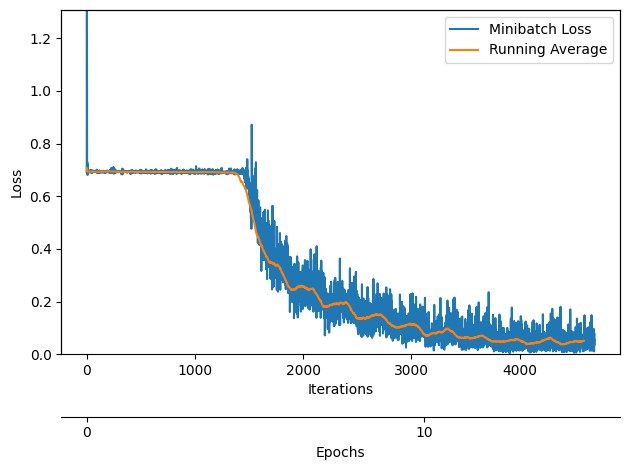

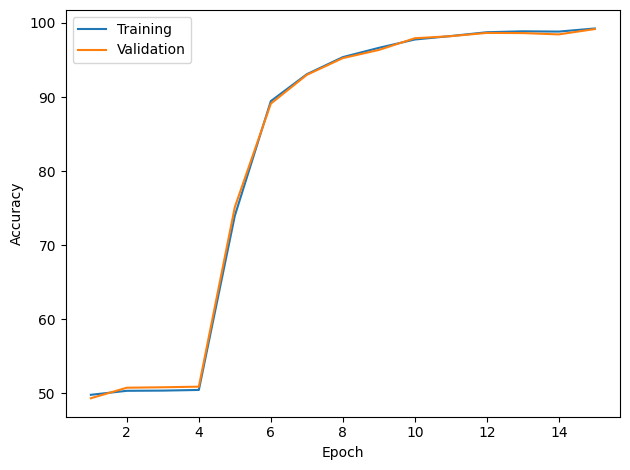

In [18]:
plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=100)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.show()

In [19]:
def predict_sentiment(model, sentence):

    model.eval()
    tokenized = tokenizer(sentence)
    indexed = [vocab[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(DEVICE)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = F.softmax(model(tensor), dim=1)
    return prediction.to("cpu").squeeze(dim=0).detach().numpy()

print('Probability positive:')
predict_sentiment(model, "This is such an awesome movie, I really love it!")[1]

Probability positive:


0.9927759

In [28]:
print('Probability positive:')
print(predict_sentiment(model, "That fight scene was dope. solid")[1])

print('Probability positive:')
predict_sentiment(model, "not my cup of tea")[1]

Probability positive:
0.99088585
Probability positive:


0.012482532